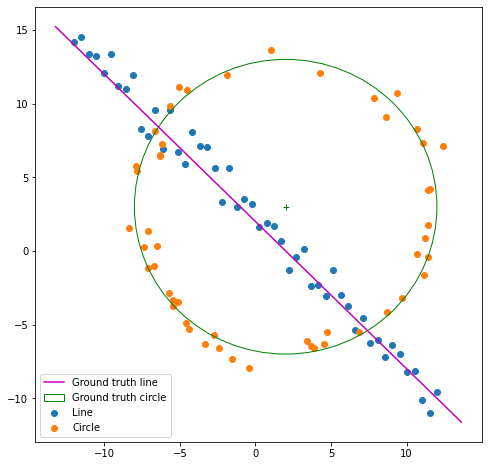

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


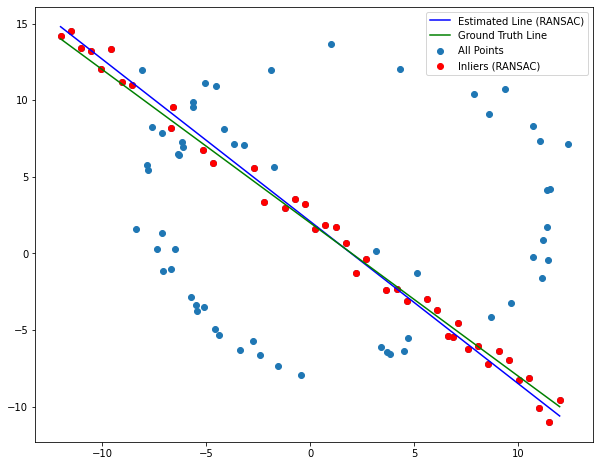

In [2]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate the total least squares error
def total_least_squares_error(params, points):
    a, b, d = params
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + d) / np.sqrt(a**2 + b**2)
    return np.sum(distances)

# RANSAC algorithm for line fitting
def ransac_line(points, iterations=5000, threshold=0.8):
    best_params = None
    best_inliers = None
    best_samples= None
    for _ in range(iterations):
        # Randomly sample two points to form a line
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample = points[sample_indices]
        # Calculate line parameters [a, b, d]
        a, b, d = np.cross([sample[0, 0], sample[0, 1], 1], [sample[1, 0], sample[1, 1], 1])

        # Apply constraint ||[a, b]|| = 1
        norm = np.linalg.norm([a, b])
        if norm != 0:
            a /= norm
            b /= norm
            d /= norm

        # Calculate inliers based on the total least squares error
        inliers = np.where(np.abs(a * points[:, 0] + b * points[:, 1] + d) / np.sqrt(a**2 + b**2) < threshold)[0]

        # Update best model if current model has more inliers
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_params = [a, b, d]
            best_inliers = inliers
            best_samples= sample

    return best_params, best_inliers, best_samples



# Run RANSAC algorithm
best_params, best_inliers, best_samples_line = ransac_line(X)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], label='All Points')
if best_inliers is not None:
    plt.scatter(X[best_inliers, 0], X[best_inliers, 1], color='r', label='Inliers (RANSAC)')
    plt.plot(x, -(best_params[0] / best_params[1]) * x - best_params[2] / best_params[1], label='Estimated Line (RANSAC)', color='b')
else:
    print("RANSAC did not find a suitable model.")

plt.plot(x, m * x + b, label='Ground Truth Line', color='g')
plt.legend()
plt.show()


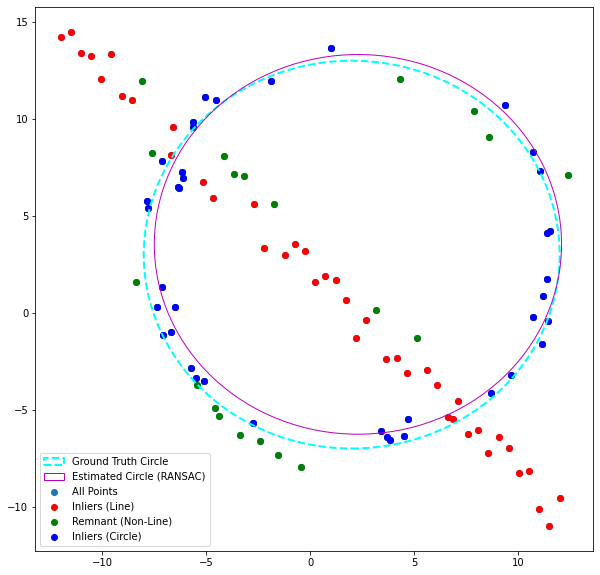

In [3]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate the total least squares error for a line
def total_least_squares_error_line(params, points):
    a, b, d = params
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + d) / np.sqrt(a**2 + b**2)
    return np.sum(distances)

# Function to calculate the radial error for a circle
def radial_error(params, points):
    x, y, r = params
    distances = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
    return np.sum(distances)

# RANSAC algorithm for circle fitting
def ransac_circle(points, iterations=1000, threshold=0.8, min_points=10):
    best_params = None
    best_inliers = None
    best_samples = None
    for _ in range(iterations):
        # Randomly sample three points to form a circle
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample = points[sample_indices]

        # Calculate circle parameters [x, y, r]
        x, y = np.mean(sample[:, 0]), np.mean(sample[:, 1])
        r = np.mean(np.sqrt((sample[:, 0] - x)**2 + (sample[:, 1] - y)**2))

        # Calculate inliers based on the radial error
        inliers = np.where(np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r) < threshold)[0]

        # Update best model if current model has more inliers
        if len(inliers) >= min_points and (best_inliers is None or len(inliers) > len(best_inliers)):
            best_params = [x, y, r]
            best_inliers = inliers
            best_samples = sample

    return best_params, best_inliers ,best_samples

# Subtract the consensus of the best line (remnant)
remnant_indices = np.setdiff1d(np.arange(len(X)), best_inliers)
remnant_points = X[remnant_indices]

# Run RANSAC algorithm for circle fitting on the remnant
best_circle_params, best_circle_inliers, best_samples_circle = ransac_circle(remnant_points)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# Ground truth circle
ground_truth_circle = plt.Circle((x0_gt, y0_gt), r, color='cyan', fill=False, linestyle='dashed', linewidth=2, label='Ground Truth Circle')
plt.gcf().gca().add_patch(ground_truth_circle)

plt.scatter(X[:, 0], X[:, 1], label='All Points')
plt.scatter(X[best_inliers, 0], X[best_inliers, 1], color='r', label='Inliers (Line)')
plt.scatter(remnant_points[:, 0], remnant_points[:, 1], color='g', label='Remnant (Non-Line)')
if best_circle_inliers is not None:
    plt.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], color='b', label='Inliers (Circle)')
    circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='m', fill=False, label='Estimated Circle (RANSAC)')
    plt.gca().add_patch(circle)
else:
    print("RANSAC did not find a suitable circle for the remnant.")

plt.legend()
plt.show()


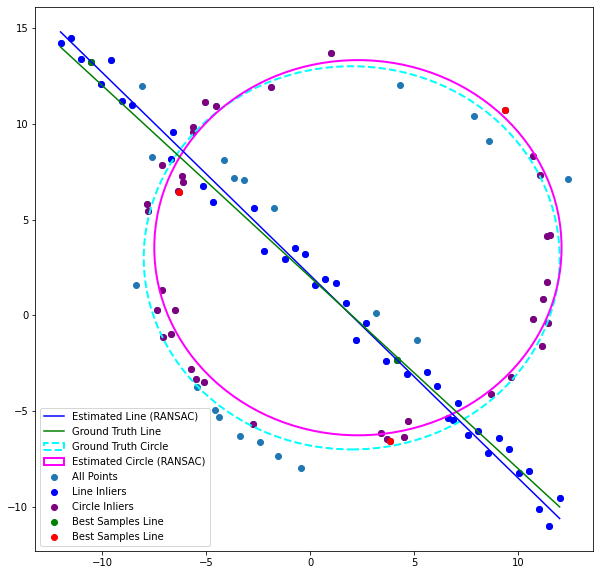

In [6]:
# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# Ground truth circle
ground_truth_circle = plt.Circle((x0_gt, y0_gt), r, color='cyan', fill=False, linestyle='dashed', linewidth=2, label='Ground Truth Circle')
plt.gcf().gca().add_patch(ground_truth_circle)

# Plot all points
plt.scatter(X[:, 0], X[:, 1], label='All Points')

# Plot the line estimated from the sample leading to the best estimate
plt.plot(x, -(best_params[0] / best_params[1]) * x - best_params[2] / best_params[1], label='Estimated Line (RANSAC)', color='b')

#Plot Ground Truth line
plt.plot(x, m * x + b, label='Ground Truth Line', color='g')

# Plot line inliers
plt.scatter(X[best_inliers, 0], X[best_inliers, 1], color='blue', label='Line Inliers')

# Plot the best-fit circle
circle_fit = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='magenta', fill=False, linewidth=2, label='Estimated Circle (RANSAC)')
plt.gca().add_patch(circle_fit)

# Plot circle inliers
if best_circle_inliers is not None:
    plt.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], color='purple', label='Circle Inliers')

plt.scatter(best_samples_line[:, 0], best_samples_line[:, 1], color='g', label='Best Samples Line ')
plt.scatter(best_samples_circle[:, 0], best_samples_circle[:, 1], color='r', label='Best Samples Line ')
plt.legend()
plt.show()